In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models,LinearRidge,CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name = "mango_729_975.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.01")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape

n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]

dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.01\mango_729_975


In [5]:
#todo write a summary

ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
if False:
    local_logger_name = f"lr"

    save_loc = log_dir/f"LR"
    if not save_loc.exists():
        save_loc.mkdir()
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger=logging.getLogger(local_logger_name)
    scheme= ev.SKLearnScheme(logger=local_logger_name)

    models_ls = {'lr':CustomWrapper(LinearRidge(1e-2))}
    local_logger.info(f"Running LR")
    scores_ls, preds_ls, model_states_ls ,train_time_ls, test_time_ls = eval.evaluate(models_ls,dataset,scheme,logger_name=local_logger_name)
    _, _, model_states_ls_final , _, _= eval.build(models_ls,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_ls.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_ls_final.items():
        model.save(save_loc/(f"{name}_final"))
    local_logger.info(f"Train times: {train_time_ls}")
    local_logger.info(f"Test times: {test_time_ls}")
    local_logger.info(f"Scores: {scores_ls}")
    for key,value in ut.flip_dicts(scores_ls).items():
        local_logger.info(f"{key}: {value}")

In [8]:
if False:
    #write preds
    preds_ls.to_csv(save_loc/ (f"predictions_lr" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds_ls,name_lambda=lambda x:f"{x}",save_lambda= lambda x:f"lr_{x}",save_loc=save_loc)
    #save scores
    flipped = ut.flip_dicts(scores_ls)
    scores_df_lr = None
    for name,record in flipped.items():
        record1 = {'model':f"LR",'n_comp':"None"}
        if scores_df_lr is None:
            scores_df_lr =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_lr=scores_df_lr.append([{**record1,**record}],ignore_index=True)



In [9]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None
for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.PCAScheme(logger=local_logger_name,whiten=False,n_components=n_component)

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk = eval.evaluate(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _= eval.build(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states_sk.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_sk_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)
        
    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)


Running PCR with 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:6.1361,knn_k=1:0.0,knn_k=5:4.5198,knn_k=10:5.1214,knn_k=20:5.4051,knn_k=50:5.6002,knn_k=100:5.6767,lwr_k=20:5.4038,lwr_k=50:5.5964,lwr_k=100:5.6531,lwr_k=200:5.6806,lwr_k=500:5.7122,lwr_k=1000:5.7313'
Tested (test) on 1905 instances with mean losses of: lr:6.1391,knn_k=1:10.7893,knn_k=5:6.6572,knn_k=10:6.2148,knn_k=20:5.9496,knn_k=50:5.7833,knn_k=100:5.7746,lwr_k=20:5.954,lwr_k=50:5.787,lwr_k=100:5.7666,lwr_k=200:5.7484,lwr_k=500:5.7338,lwr_k=1000:5.7271'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:6.1114,knn_k=1:0.0,knn_k=5:4.4711,knn_k=10:5.0939,knn_k=20:5.4165,knn_k=50:5.5859,knn_k=100:5.6841,lwr_k=20:5.414,lwr_k=50:5.5777,lwr_k=100:5.6582,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:6.0311,knn_k=1:0.0,knn_k=5:3.8001,knn_k=10:4.5682,knn_k=20:4.9678,knn_k=50:5.2396,knn_k=100:5.3607,lwr_k=20:4.9147,lwr_k=50:5.1672,lwr_k=100:5.2529,lwr_k=200:5.3147,lwr_k=500:5.3865,lwr_k=1000:5.4396'
Tested (test) on 1905 instances with mean losses of: lr:6.1132,knn_k=1:8.0276,knn_k=5:5.9127,knn_k=10:5.7339,knn_k=20:5.5418,knn_k=50:5.503,knn_k=100:5.452,lwr_k=20:5.4995,lwr_k=50:5.4444,lwr_k=100:5.3679,lwr_k=200:5.345,lwr_k=500:5.4237,lwr_k=1000:5.464'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.9871,knn_k=1:0.0,knn_k=5:3.7816,knn_k=10:4.5631,knn_k=20:4.9752,knn_k=50:5.2235,knn_k=100:5.3401,lwr_k=20:4.9275,lwr_k=50:5.149,lwr_k=100:5.2476,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.66,knn_k=1:0.0,knn_k=5:3.3253,knn_k=10:4.1226,knn_k=20:4.5173,knn_k=50:4.7859,knn_k=100:4.9149,lwr_k=20:4.3556,lwr_k=50:4.5917,lwr_k=100:4.6628,lwr_k=200:4.7492,lwr_k=500:4.889,lwr_k=1000:4.9865'
Tested (test) on 1905 instances with mean losses of: lr:5.631,knn_k=1:5.3733,knn_k=5:4.971,knn_k=10:4.8185,knn_k=20:4.7949,knn_k=50:4.8725,knn_k=100:4.95,lwr_k=20:4.6784,lwr_k=50:4.6995,lwr_k=100:4.7021,lwr_k=200:4.6929,lwr_k=500:4.845,lwr_k=1000:4.9463'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.6061,knn_k=1:0.0,knn_k=5:3.3798,knn_k=10:4.1526,knn_k=20:4.489,knn_k=50:4.7632,knn_k=100:4.9262,lwr_k=20:4.3179,lwr_k=50:4.5812,lwr_k=100:4.6881,lwr_k=200:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.4888,knn_k=1:0.0,knn_k=5:3.266,knn_k=10:3.9638,knn_k=20:4.3543,knn_k=50:4.7026,knn_k=100:4.8855,lwr_k=20:4.0954,lwr_k=50:4.3664,lwr_k=100:4.4959,lwr_k=200:4.5956,lwr_k=500:4.7424,lwr_k=1000:4.8297'
Tested (test) on 1905 instances with mean losses of: lr:5.5216,knn_k=1:4.8632,knn_k=5:4.7961,knn_k=10:4.5784,knn_k=20:4.6876,knn_k=50:4.7687,knn_k=100:4.9121,lwr_k=20:4.5159,lwr_k=50:4.4903,lwr_k=100:4.5542,lwr_k=200:4.541,lwr_k=500:4.7163,lwr_k=1000:4.7849'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.4795,knn_k=1:0.0,knn_k=5:3.2724,knn_k=10:4.0103,knn_k=20:4.3633,knn_k=50:4.6911,knn_k=100:4.8894,lwr_k=20:4.0999,lwr_k=50:4.3815,lwr_k=100:4.5317,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:3.8739,knn_k=1:0.0,knn_k=5:2.8657,knn_k=10:3.5514,knn_k=20:3.9809,knn_k=50:4.4544,knn_k=100:4.7332,lwr_k=20:3.6072,lwr_k=50:3.8088,lwr_k=100:3.7826,lwr_k=200:3.6786,lwr_k=500:3.6112,lwr_k=1000:3.6174'
Tested (test) on 1905 instances with mean losses of: lr:3.9648,knn_k=1:4.0295,knn_k=5:4.0949,knn_k=10:4.1013,knn_k=20:4.2821,knn_k=50:4.5394,knn_k=100:4.7616,lwr_k=20:4.0005,lwr_k=50:3.971,lwr_k=100:3.8767,lwr_k=200:3.7171,lwr_k=500:3.6953,lwr_k=1000:3.6996'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:3.9498,knn_k=1:0.0,knn_k=5:2.8614,knn_k=10:3.5864,knn_k=20:4.0065,knn_k=50:4.4722,knn_k=100:4.746,lwr_k=20:3.6246,lwr_k=50:3.8439,lwr_k=100:3.8347,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:3.5158,knn_k=1:0.0,knn_k=5:2.6971,knn_k=10:3.409,knn_k=20:3.9122,knn_k=50:4.4076,knn_k=100:4.6974,lwr_k=20:3.4672,lwr_k=50:3.6278,lwr_k=100:3.5318,lwr_k=200:3.3426,lwr_k=500:3.1954,lwr_k=1000:3.2117'
Tested (test) on 1905 instances with mean losses of: lr:3.5571,knn_k=1:3.9452,knn_k=5:3.9028,knn_k=10:3.9868,knn_k=20:4.2279,knn_k=50:4.4983,knn_k=100:4.7298,lwr_k=20:3.894,lwr_k=50:3.8083,lwr_k=100:3.6371,lwr_k=200:3.383,lwr_k=500:3.2604,lwr_k=1000:3.2693'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:3.5419,knn_k=1:0.0,knn_k=5:2.6846,knn_k=10:3.4633,knn_k=20:3.9136,knn_k=50:4.4098,knn_k=100:4.7104,lwr_k=20:3.4638,lwr_k=50:3.6531,lwr_k=100:3.5695,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.5477,knn_k=1:0.0,knn_k=5:2.6095,knn_k=10:3.3386,knn_k=20:3.8531,knn_k=50:4.3767,knn_k=100:4.6762,lwr_k=20:3.3814,lwr_k=50:3.52,lwr_k=100:3.359,lwr_k=200:3.041,lwr_k=500:2.5657,lwr_k=1000:2.2157'
Tested (test) on 1905 instances with mean losses of: lr:1.5676,knn_k=1:3.7661,knn_k=5:3.8145,knn_k=10:3.9165,knn_k=20:4.1569,knn_k=50:4.466,knn_k=100:4.7067,lwr_k=20:3.7979,lwr_k=50:3.696,lwr_k=100:3.457,lwr_k=200:3.0738,lwr_k=500:2.6166,lwr_k=1000:2.2513'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.5343,knn_k=1:0.0,knn_k=5:2.5847,knn_k=10:3.3973,knn_k=20:3.8536,knn_k=50:4.3752,knn_k=100:4.6859,lwr_k=20:3.3787,lwr_k=50:3.5423,lwr_k=100:3.3904,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.0904,knn_k=1:0.0,knn_k=5:2.6014,knn_k=10:3.3049,knn_k=20:3.841,knn_k=50:4.3708,knn_k=100:4.6722,lwr_k=20:3.3603,lwr_k=50:3.4947,lwr_k=100:3.3172,lwr_k=200:2.9708,lwr_k=500:2.4154,lwr_k=1000:1.9721'
Tested (test) on 1905 instances with mean losses of: lr:1.0822,knn_k=1:3.7686,knn_k=5:3.7877,knn_k=10:3.9008,knn_k=20:4.1432,knn_k=50:4.4549,knn_k=100:4.7017,lwr_k=20:3.7796,lwr_k=50:3.6707,lwr_k=100:3.4147,lwr_k=200:2.9998,lwr_k=500:2.4495,lwr_k=1000:1.9868'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.0895,knn_k=1:0.0,knn_k=5:2.5577,knn_k=10:3.3761,knn_k=20:3.8449,knn_k=50:4.3669,knn_k=100:4.6825,lwr_k=20:3.3601,lwr_k=50:3.5162,lwr_k=100:3.3479,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9997,knn_k=1:0.0,knn_k=5:2.5967,knn_k=10:3.3062,knn_k=20:3.8402,knn_k=50:4.3692,knn_k=100:4.671,lwr_k=20:3.3574,lwr_k=50:3.4898,lwr_k=100:3.3109,lwr_k=200:2.9614,lwr_k=500:2.4006,lwr_k=1000:1.951'
Tested (test) on 1905 instances with mean losses of: lr:0.9949,knn_k=1:3.7495,knn_k=5:3.7811,knn_k=10:3.899,knn_k=20:4.1415,knn_k=50:4.4533,knn_k=100:4.7018,lwr_k=20:3.7756,lwr_k=50:3.6671,lwr_k=100:3.4081,lwr_k=200:2.9916,lwr_k=500:2.4351,lwr_k=1000:1.9672'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9949,knn_k=1:0.0,knn_k=5:2.5579,knn_k=10:3.3713,knn_k=20:3.8455,knn_k=50:4.366,knn_k=100:4.681,lwr_k=20:3.3582,lwr_k=50:3.5111,lwr_k=100:3.341,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9997,knn_k=1:0.0,knn_k=5:2.5986,knn_k=10:3.3058,knn_k=20:3.8396,knn_k=50:4.3694,knn_k=100:4.671,lwr_k=20:3.3569,lwr_k=50:3.4894,lwr_k=100:3.3103,lwr_k=200:2.9606,lwr_k=500:2.3998,lwr_k=1000:1.9502'
Tested (test) on 1905 instances with mean losses of: lr:0.9949,knn_k=1:3.7507,knn_k=5:3.7825,knn_k=10:3.8991,knn_k=20:4.1406,knn_k=50:4.4531,knn_k=100:4.7024,lwr_k=20:3.7746,lwr_k=50:3.6656,lwr_k=100:3.4084,lwr_k=200:2.9913,lwr_k=500:2.4342,lwr_k=1000:1.9664'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9948,knn_k=1:0.0,knn_k=5:2.5581,knn_k=10:3.3696,knn_k=20:3.8455,knn_k=50:4.3657,knn_k=100:4.6812,lwr_k=20:3.3579,lwr_k=50:3.5107,lwr_k=100:3.3403,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9997,knn_k=1:0.0,knn_k=5:2.597,knn_k=10:3.3052,knn_k=20:3.84,knn_k=50:4.3691,knn_k=100:4.6711,lwr_k=20:3.357,lwr_k=50:3.4893,lwr_k=100:3.3099,lwr_k=200:2.9603,lwr_k=500:2.3992,lwr_k=1000:1.9498'
Tested (test) on 1905 instances with mean losses of: lr:0.9949,knn_k=1:3.7478,knn_k=5:3.7789,knn_k=10:3.8963,knn_k=20:4.1422,knn_k=50:4.4531,knn_k=100:4.7022,lwr_k=20:3.7764,lwr_k=50:3.6652,lwr_k=100:3.408,lwr_k=200:2.9907,lwr_k=500:2.4338,lwr_k=1000:1.9662'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9946,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3704,knn_k=20:3.8445,knn_k=50:4.3661,knn_k=100:4.6813,lwr_k=20:3.3567,lwr_k=50:3.5106,lwr_k=100:3.34,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9876,knn_k=1:0.0,knn_k=5:2.5975,knn_k=10:3.3043,knn_k=20:3.8398,knn_k=50:4.369,knn_k=100:4.6713,lwr_k=20:3.3567,lwr_k=50:3.489,lwr_k=100:3.3098,lwr_k=200:2.9602,lwr_k=500:2.3991,lwr_k=1000:1.9497'
Tested (test) on 1905 instances with mean losses of: lr:0.9919,knn_k=1:3.7354,knn_k=5:3.7794,knn_k=10:3.8967,knn_k=20:4.1438,knn_k=50:4.4524,knn_k=100:4.702,lwr_k=20:3.7776,lwr_k=50:3.6652,lwr_k=100:3.4077,lwr_k=200:2.9906,lwr_k=500:2.4338,lwr_k=1000:1.9661'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9847,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3705,knn_k=20:3.8455,knn_k=50:4.3655,knn_k=100:4.6811,lwr_k=20:3.3573,lwr_k=50:3.5101,lwr_k=100:3.3395,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9538,knn_k=1:0.0,knn_k=5:2.5959,knn_k=10:3.3048,knn_k=20:3.8386,knn_k=50:4.3689,knn_k=100:4.6711,lwr_k=20:3.3554,lwr_k=50:3.4887,lwr_k=100:3.3095,lwr_k=200:2.9599,lwr_k=500:2.3987,lwr_k=1000:1.9491'
Tested (test) on 1905 instances with mean losses of: lr:0.9648,knn_k=1:3.7354,knn_k=5:3.7789,knn_k=10:3.8951,knn_k=20:4.1425,knn_k=50:4.4533,knn_k=100:4.702,lwr_k=20:3.7765,lwr_k=50:3.666,lwr_k=100:3.4079,lwr_k=200:2.9905,lwr_k=500:2.4335,lwr_k=1000:1.9656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9649,knn_k=1:0.0,knn_k=5:2.5572,knn_k=10:3.371,knn_k=20:3.8452,knn_k=50:4.3659,knn_k=100:4.6809,lwr_k=20:3.3569,lwr_k=50:3.5101,lwr_k=100:3.3392,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9116,knn_k=1:0.0,knn_k=5:2.5978,knn_k=10:3.3049,knn_k=20:3.8391,knn_k=50:4.3686,knn_k=100:4.6712,lwr_k=20:3.3557,lwr_k=50:3.4884,lwr_k=100:3.3093,lwr_k=200:2.9595,lwr_k=500:2.398,lwr_k=1000:1.9478'
Tested (test) on 1905 instances with mean losses of: lr:0.927,knn_k=1:3.7354,knn_k=5:3.7774,knn_k=10:3.8949,knn_k=20:4.1422,knn_k=50:4.4535,knn_k=100:4.7019,lwr_k=20:3.776,lwr_k=50:3.6661,lwr_k=100:3.4075,lwr_k=200:2.9901,lwr_k=500:2.4327,lwr_k=1000:1.9645'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9229,knn_k=1:0.0,knn_k=5:2.5578,knn_k=10:3.3712,knn_k=20:3.8444,knn_k=50:4.3655,knn_k=100:4.6809,lwr_k=20:3.3562,lwr_k=50:3.5096,lwr_k=100:3.3388,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.909,knn_k=1:0.0,knn_k=5:2.5964,knn_k=10:3.306,knn_k=20:3.8388,knn_k=50:4.3688,knn_k=100:4.6711,lwr_k=20:3.3553,lwr_k=50:3.4881,lwr_k=100:3.3091,lwr_k=200:2.9592,lwr_k=500:2.3978,lwr_k=1000:1.9477'
Tested (test) on 1905 instances with mean losses of: lr:0.9272,knn_k=1:3.7356,knn_k=5:3.7774,knn_k=10:3.8965,knn_k=20:4.143,knn_k=50:4.4535,knn_k=100:4.7012,lwr_k=20:3.7766,lwr_k=50:3.6658,lwr_k=100:3.4074,lwr_k=200:2.9899,lwr_k=500:2.4325,lwr_k=1000:1.9644'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9187,knn_k=1:0.0,knn_k=5:2.5577,knn_k=10:3.3714,knn_k=20:3.8451,knn_k=50:4.3656,knn_k=100:4.6808,lwr_k=20:3.3566,lwr_k=50:3.5095,lwr_k=100:3.3388,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9089,knn_k=1:0.0,knn_k=5:2.5977,knn_k=10:3.3053,knn_k=20:3.8391,knn_k=50:4.3686,knn_k=100:4.6709,lwr_k=20:3.3557,lwr_k=50:3.4882,lwr_k=100:3.3091,lwr_k=200:2.9592,lwr_k=500:2.3978,lwr_k=1000:1.9476'
Tested (test) on 1905 instances with mean losses of: lr:0.9271,knn_k=1:3.7356,knn_k=5:3.7774,knn_k=10:3.8966,knn_k=20:4.1426,knn_k=50:4.4532,knn_k=100:4.7011,lwr_k=20:3.7762,lwr_k=50:3.6655,lwr_k=100:3.4073,lwr_k=200:2.9899,lwr_k=500:2.4325,lwr_k=1000:1.9643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9186,knn_k=1:0.0,knn_k=5:2.5596,knn_k=10:3.3704,knn_k=20:3.8448,knn_k=50:4.3658,knn_k=100:4.681,lwr_k=20:3.3564,lwr_k=50:3.5096,lwr_k=100:3.3389,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9081,knn_k=1:0.0,knn_k=5:2.5962,knn_k=10:3.3045,knn_k=20:3.8392,knn_k=50:4.3691,knn_k=100:4.671,lwr_k=20:3.3555,lwr_k=50:3.4883,lwr_k=100:3.3091,lwr_k=200:2.959,lwr_k=500:2.3977,lwr_k=1000:1.9476'
Tested (test) on 1905 instances with mean losses of: lr:0.9244,knn_k=1:3.7356,knn_k=5:3.7774,knn_k=10:3.8966,knn_k=20:4.1424,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.776,lwr_k=50:3.6658,lwr_k=100:3.4071,lwr_k=200:2.9898,lwr_k=500:2.4325,lwr_k=1000:1.9643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9186,knn_k=1:0.0,knn_k=5:2.5586,knn_k=10:3.3709,knn_k=20:3.8448,knn_k=50:4.3662,knn_k=100:4.6808,lwr_k=20:3.3564,lwr_k=50:3.5097,lwr_k=100:3.3387,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9026,knn_k=1:0.0,knn_k=5:2.5954,knn_k=10:3.3042,knn_k=20:3.8391,knn_k=50:4.3688,knn_k=100:4.6711,lwr_k=20:3.3556,lwr_k=50:3.4879,lwr_k=100:3.309,lwr_k=200:2.959,lwr_k=500:2.3976,lwr_k=1000:1.9475'
Tested (test) on 1905 instances with mean losses of: lr:0.9263,knn_k=1:3.7356,knn_k=5:3.7774,knn_k=10:3.8962,knn_k=20:4.1433,knn_k=50:4.4532,knn_k=100:4.7011,lwr_k=20:3.7765,lwr_k=50:3.6655,lwr_k=100:3.4071,lwr_k=200:2.9897,lwr_k=500:2.4325,lwr_k=1000:1.9643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9108,knn_k=1:0.0,knn_k=5:2.5579,knn_k=10:3.37,knn_k=20:3.8446,knn_k=50:4.3661,knn_k=100:4.6807,lwr_k=20:3.3564,lwr_k=50:3.5096,lwr_k=100:3.3388,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9004,knn_k=1:0.0,knn_k=5:2.5956,knn_k=10:3.3053,knn_k=20:3.8389,knn_k=50:4.3687,knn_k=100:4.6709,lwr_k=20:3.3552,lwr_k=50:3.4879,lwr_k=100:3.3089,lwr_k=200:2.959,lwr_k=500:2.3976,lwr_k=1000:1.9475'
Tested (test) on 1905 instances with mean losses of: lr:0.9247,knn_k=1:3.7356,knn_k=5:3.7776,knn_k=10:3.8949,knn_k=20:4.1433,knn_k=50:4.4526,knn_k=100:4.7013,lwr_k=20:3.7765,lwr_k=50:3.6649,lwr_k=100:3.4072,lwr_k=200:2.9897,lwr_k=500:2.4325,lwr_k=1000:1.9643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9082,knn_k=1:0.0,knn_k=5:2.5578,knn_k=10:3.3705,knn_k=20:3.8444,knn_k=50:4.366,knn_k=100:4.6806,lwr_k=20:3.3562,lwr_k=50:3.5094,lwr_k=100:3.3387,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8661,knn_k=1:0.0,knn_k=5:2.5977,knn_k=10:3.3056,knn_k=20:3.8392,knn_k=50:4.3687,knn_k=100:4.6711,lwr_k=20:3.3554,lwr_k=50:3.4878,lwr_k=100:3.3089,lwr_k=200:2.9589,lwr_k=500:2.3975,lwr_k=1000:1.9473'
Tested (test) on 1905 instances with mean losses of: lr:0.8866,knn_k=1:3.7356,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1437,knn_k=50:4.4532,knn_k=100:4.7014,lwr_k=20:3.7769,lwr_k=50:3.6657,lwr_k=100:3.4073,lwr_k=200:2.9897,lwr_k=500:2.4323,lwr_k=1000:1.9641'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.878,knn_k=1:0.0,knn_k=5:2.5577,knn_k=10:3.3704,knn_k=20:3.8446,knn_k=50:4.3661,knn_k=100:4.6805,lwr_k=20:3.3564,lwr_k=50:3.5096,lwr_k=100:3.3386,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8651,knn_k=1:0.0,knn_k=5:2.5976,knn_k=10:3.3054,knn_k=20:3.8392,knn_k=50:4.3688,knn_k=100:4.6711,lwr_k=20:3.3553,lwr_k=50:3.4877,lwr_k=100:3.3088,lwr_k=200:2.9589,lwr_k=500:2.3975,lwr_k=1000:1.9473'
Tested (test) on 1905 instances with mean losses of: lr:0.8844,knn_k=1:3.7356,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1435,knn_k=50:4.4531,knn_k=100:4.7014,lwr_k=20:3.7767,lwr_k=50:3.6655,lwr_k=100:3.4072,lwr_k=200:2.9896,lwr_k=500:2.4323,lwr_k=1000:1.9641'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8767,knn_k=1:0.0,knn_k=5:2.5577,knn_k=10:3.3704,knn_k=20:3.8447,knn_k=50:4.3659,knn_k=100:4.6806,lwr_k=20:3.3565,lwr_k=50:3.5094,lwr_k=100:3.3386,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8618,knn_k=1:0.0,knn_k=5:2.5972,knn_k=10:3.3054,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6712,lwr_k=20:3.3553,lwr_k=50:3.4875,lwr_k=100:3.3088,lwr_k=200:2.9589,lwr_k=500:2.3974,lwr_k=1000:1.9473'
Tested (test) on 1905 instances with mean losses of: lr:0.881,knn_k=1:3.7356,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1445,knn_k=50:4.4534,knn_k=100:4.7013,lwr_k=20:3.7776,lwr_k=50:3.6656,lwr_k=100:3.4072,lwr_k=200:2.9897,lwr_k=500:2.4323,lwr_k=1000:1.9641'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8669,knn_k=1:0.0,knn_k=5:2.5581,knn_k=10:3.3707,knn_k=20:3.8445,knn_k=50:4.3661,knn_k=100:4.6805,lwr_k=20:3.3562,lwr_k=50:3.5095,lwr_k=100:3.3384,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8607,knn_k=1:0.0,knn_k=5:2.5972,knn_k=10:3.3054,knn_k=20:3.8392,knn_k=50:4.3686,knn_k=100:4.6712,lwr_k=20:3.3554,lwr_k=50:3.4875,lwr_k=100:3.3088,lwr_k=200:2.9589,lwr_k=500:2.3974,lwr_k=1000:1.9473'
Tested (test) on 1905 instances with mean losses of: lr:0.8789,knn_k=1:3.7356,knn_k=5:3.7772,knn_k=10:3.8961,knn_k=20:4.1443,knn_k=50:4.4533,knn_k=100:4.7014,lwr_k=20:3.7775,lwr_k=50:3.6656,lwr_k=100:3.4072,lwr_k=200:2.9896,lwr_k=500:2.4323,lwr_k=1000:1.9641'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8642,knn_k=1:0.0,knn_k=5:2.5567,knn_k=10:3.37,knn_k=20:3.8443,knn_k=50:4.366,knn_k=100:4.6805,lwr_k=20:3.356,lwr_k=50:3.5095,lwr_k=100:3.3384,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8468,knn_k=1:0.0,knn_k=5:2.5959,knn_k=10:3.3055,knn_k=20:3.8401,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3561,lwr_k=50:3.4875,lwr_k=100:3.3087,lwr_k=200:2.9588,lwr_k=500:2.3973,lwr_k=1000:1.9472'
Tested (test) on 1905 instances with mean losses of: lr:0.8686,knn_k=1:3.7356,knn_k=5:3.7772,knn_k=10:3.8959,knn_k=20:4.1444,knn_k=50:4.4533,knn_k=100:4.7013,lwr_k=20:3.7775,lwr_k=50:3.6656,lwr_k=100:3.407,lwr_k=200:2.9897,lwr_k=500:2.4322,lwr_k=1000:1.964'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8592,knn_k=1:0.0,knn_k=5:2.5579,knn_k=10:3.37,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6806,lwr_k=20:3.356,lwr_k=50:3.5093,lwr_k=100:3.3385,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8449,knn_k=1:0.0,knn_k=5:2.5961,knn_k=10:3.3056,knn_k=20:3.8394,knn_k=50:4.3684,knn_k=100:4.6711,lwr_k=20:3.3556,lwr_k=50:3.4874,lwr_k=100:3.3087,lwr_k=200:2.9588,lwr_k=500:2.3973,lwr_k=1000:1.9471'
Tested (test) on 1905 instances with mean losses of: lr:0.8621,knn_k=1:3.7578,knn_k=5:3.7772,knn_k=10:3.8959,knn_k=20:4.1438,knn_k=50:4.4533,knn_k=100:4.7013,lwr_k=20:3.7772,lwr_k=50:3.6656,lwr_k=100:3.407,lwr_k=200:2.9896,lwr_k=500:2.4322,lwr_k=1000:1.9639'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8573,knn_k=1:0.0,knn_k=5:2.5568,knn_k=10:3.37,knn_k=20:3.8444,knn_k=50:4.3658,knn_k=100:4.6806,lwr_k=20:3.3559,lwr_k=50:3.5094,lwr_k=100:3.3385,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8423,knn_k=1:0.0,knn_k=5:2.5962,knn_k=10:3.3053,knn_k=20:3.8393,knn_k=50:4.3684,knn_k=100:4.6711,lwr_k=20:3.3553,lwr_k=50:3.4873,lwr_k=100:3.3086,lwr_k=200:2.9589,lwr_k=500:2.3973,lwr_k=1000:1.9471'
Tested (test) on 1905 instances with mean losses of: lr:0.8611,knn_k=1:3.7578,knn_k=5:3.7772,knn_k=10:3.8959,knn_k=20:4.1438,knn_k=50:4.454,knn_k=100:4.7012,lwr_k=20:3.7772,lwr_k=50:3.6662,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4321,lwr_k=1000:1.9639'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.855,knn_k=1:0.0,knn_k=5:2.5572,knn_k=10:3.3705,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6806,lwr_k=20:3.3559,lwr_k=50:3.5093,lwr_k=100:3.3384,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8422,knn_k=1:0.0,knn_k=5:2.5959,knn_k=10:3.3053,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3552,lwr_k=50:3.4874,lwr_k=100:3.3086,lwr_k=200:2.9589,lwr_k=500:2.3972,lwr_k=1000:1.947'
Tested (test) on 1905 instances with mean losses of: lr:0.8611,knn_k=1:3.7356,knn_k=5:3.7772,knn_k=10:3.8969,knn_k=20:4.1437,knn_k=50:4.4533,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6656,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4322,lwr_k=1000:1.9638'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8548,knn_k=1:0.0,knn_k=5:2.5571,knn_k=10:3.3704,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6805,lwr_k=20:3.3558,lwr_k=50:3.5092,lwr_k=100:3.3383,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8423,knn_k=1:0.0,knn_k=5:2.5959,knn_k=10:3.3051,knn_k=20:3.8391,knn_k=50:4.3684,knn_k=100:4.6712,lwr_k=20:3.355,lwr_k=50:3.4873,lwr_k=100:3.3087,lwr_k=200:2.9588,lwr_k=500:2.3972,lwr_k=1000:1.947'
Tested (test) on 1905 instances with mean losses of: lr:0.8613,knn_k=1:3.7578,knn_k=5:3.7772,knn_k=10:3.8969,knn_k=20:4.1438,knn_k=50:4.4533,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6656,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4321,lwr_k=1000:1.9638'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8548,knn_k=1:0.0,knn_k=5:2.5568,knn_k=10:3.3704,knn_k=20:3.8446,knn_k=50:4.3659,knn_k=100:4.6806,lwr_k=20:3.3559,lwr_k=50:3.5093,lwr_k=100:3.3383,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8375,knn_k=1:0.0,knn_k=5:2.5959,knn_k=10:3.305,knn_k=20:3.839,knn_k=50:4.3685,knn_k=100:4.6712,lwr_k=20:3.3549,lwr_k=50:3.4874,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3972,lwr_k=1000:1.947'
Tested (test) on 1905 instances with mean losses of: lr:0.8581,knn_k=1:3.7356,knn_k=5:3.7772,knn_k=10:3.8972,knn_k=20:4.1439,knn_k=50:4.4531,knn_k=100:4.7014,lwr_k=20:3.7772,lwr_k=50:3.6656,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4321,lwr_k=1000:1.9638'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8512,knn_k=1:0.0,knn_k=5:2.5567,knn_k=10:3.3704,knn_k=20:3.8442,knn_k=50:4.3658,knn_k=100:4.6805,lwr_k=20:3.3556,lwr_k=50:3.5092,lwr_k=100:3.3382,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8354,knn_k=1:0.0,knn_k=5:2.5956,knn_k=10:3.305,knn_k=20:3.8391,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3549,lwr_k=50:3.4874,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3972,lwr_k=1000:1.947'
Tested (test) on 1905 instances with mean losses of: lr:0.8573,knn_k=1:3.7356,knn_k=5:3.7772,knn_k=10:3.897,knn_k=20:4.1443,knn_k=50:4.4531,knn_k=100:4.7014,lwr_k=20:3.7775,lwr_k=50:3.6656,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4321,lwr_k=1000:1.9638'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8504,knn_k=1:0.0,knn_k=5:2.555,knn_k=10:3.3704,knn_k=20:3.8442,knn_k=50:4.3658,knn_k=100:4.6805,lwr_k=20:3.3555,lwr_k=50:3.5092,lwr_k=100:3.3382,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8332,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.305,knn_k=20:3.8391,knn_k=50:4.3684,knn_k=100:4.671,lwr_k=20:3.3549,lwr_k=50:3.4874,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3972,lwr_k=1000:1.947'
Tested (test) on 1905 instances with mean losses of: lr:0.8504,knn_k=1:3.7356,knn_k=5:3.7777,knn_k=10:3.897,knn_k=20:4.1444,knn_k=50:4.4531,knn_k=100:4.7013,lwr_k=20:3.7776,lwr_k=50:3.6656,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4321,lwr_k=1000:1.9637'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8477,knn_k=1:0.0,knn_k=5:2.555,knn_k=10:3.3702,knn_k=20:3.8436,knn_k=50:4.3657,knn_k=100:4.6805,lwr_k=20:3.355,lwr_k=50:3.5092,lwr_k=100:3.3382,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8295,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4873,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3972,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.8409,knn_k=1:3.7578,knn_k=5:3.7777,knn_k=10:3.8967,knn_k=20:4.1444,knn_k=50:4.4538,knn_k=100:4.7013,lwr_k=20:3.7776,lwr_k=50:3.6662,lwr_k=100:3.4069,lwr_k=200:2.9896,lwr_k=500:2.4322,lwr_k=1000:1.9637'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8423,knn_k=1:0.0,knn_k=5:2.5566,knn_k=10:3.3706,knn_k=20:3.8436,knn_k=50:4.3656,knn_k=100:4.6805,lwr_k=20:3.355,lwr_k=50:3.509,lwr_k=100:3.3382,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8199,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.305,knn_k=20:3.8391,knn_k=50:4.3685,knn_k=100:4.671,lwr_k=20:3.355,lwr_k=50:3.4873,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.8243,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8967,knn_k=20:4.144,knn_k=50:4.4538,knn_k=100:4.7012,lwr_k=20:3.7773,lwr_k=50:3.6662,lwr_k=100:3.4068,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9637'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.828,knn_k=1:0.0,knn_k=5:2.5566,knn_k=10:3.3703,knn_k=20:3.8436,knn_k=50:4.3656,knn_k=100:4.6805,lwr_k=20:3.355,lwr_k=50:3.509,lwr_k=100:3.3382,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8149,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8391,knn_k=50:4.3686,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4873,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.82,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8964,knn_k=20:4.1439,knn_k=50:4.4531,knn_k=100:4.7013,lwr_k=20:3.7772,lwr_k=50:3.6656,lwr_k=100:3.4068,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9637'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8277,knn_k=1:0.0,knn_k=5:2.5566,knn_k=10:3.3702,knn_k=20:3.8437,knn_k=50:4.3656,knn_k=100:4.6805,lwr_k=20:3.355,lwr_k=50:3.5091,lwr_k=100:3.3381,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8131,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4873,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.8175,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8964,knn_k=20:4.1439,knn_k=50:4.4531,knn_k=100:4.7013,lwr_k=20:3.7772,lwr_k=50:3.6656,lwr_k=100:3.4068,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9637'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8259,knn_k=1:0.0,knn_k=5:2.5566,knn_k=10:3.37,knn_k=20:3.8441,knn_k=50:4.3656,knn_k=100:4.6805,lwr_k=20:3.3554,lwr_k=50:3.509,lwr_k=100:3.3381,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.812,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8392,knn_k=50:4.3686,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4873,lwr_k=100:3.3085,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.8171,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8964,knn_k=20:4.1439,knn_k=50:4.4531,knn_k=100:4.7013,lwr_k=20:3.7772,lwr_k=50:3.6656,lwr_k=100:3.4068,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.823,knn_k=1:0.0,knn_k=5:2.5568,knn_k=10:3.3702,knn_k=20:3.8442,knn_k=50:4.3657,knn_k=100:4.6805,lwr_k=20:3.3554,lwr_k=50:3.509,lwr_k=100:3.3381,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8119,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9469'
Tested (test) on 1905 instances with mean losses of: lr:0.8175,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8967,knn_k=20:4.1439,knn_k=50:4.4538,knn_k=100:4.7014,lwr_k=20:3.7772,lwr_k=50:3.6661,lwr_k=100:3.4068,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.823,knn_k=1:0.0,knn_k=5:2.5568,knn_k=10:3.3702,knn_k=20:3.8438,knn_k=50:4.3658,knn_k=100:4.6804,lwr_k=20:3.3552,lwr_k=50:3.5091,lwr_k=100:3.338,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8067,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.305,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8106,knn_k=1:3.7561,knn_k=5:3.7777,knn_k=10:3.8967,knn_k=20:4.1439,knn_k=50:4.4538,knn_k=100:4.7013,lwr_k=20:3.7772,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9895,lwr_k=500:2.4321,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8167,knn_k=1:0.0,knn_k=5:2.5567,knn_k=10:3.3704,knn_k=20:3.8442,knn_k=50:4.3655,knn_k=100:4.6803,lwr_k=20:3.3555,lwr_k=50:3.5089,lwr_k=100:3.3379,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8062,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.305,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3086,lwr_k=200:2.9587,lwr_k=500:2.3971,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8118,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8967,knn_k=20:4.1435,knn_k=50:4.4538,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4068,lwr_k=200:2.9894,lwr_k=500:2.4321,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8166,knn_k=1:0.0,knn_k=5:2.5567,knn_k=10:3.3704,knn_k=20:3.8442,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3555,lwr_k=50:3.509,lwr_k=100:3.3379,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8048,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.3051,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.3971,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8065,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8967,knn_k=20:4.1433,knn_k=50:4.4538,knn_k=100:4.7014,lwr_k=20:3.7767,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8147,knn_k=1:0.0,knn_k=5:2.5568,knn_k=10:3.3704,knn_k=20:3.8442,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3555,lwr_k=50:3.509,lwr_k=100:3.3379,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8045,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3051,knn_k=20:3.8392,knn_k=50:4.3684,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.3971,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.806,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8967,knn_k=20:4.1433,knn_k=50:4.4538,knn_k=100:4.7013,lwr_k=20:3.7767,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8152,knn_k=1:0.0,knn_k=5:2.5569,knn_k=10:3.3701,knn_k=20:3.8446,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3379,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8047,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.3051,knn_k=20:3.8392,knn_k=50:4.3684,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8066,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8964,knn_k=20:4.1433,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7767,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8149,knn_k=1:0.0,knn_k=5:2.5569,knn_k=10:3.3701,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3559,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8041,knn_k=1:0.0,knn_k=5:2.5957,knn_k=10:3.3052,knn_k=20:3.8392,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3553,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8048,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8964,knn_k=20:4.1436,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8147,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3699,knn_k=20:3.8446,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3559,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8038,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3052,knn_k=20:3.839,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3548,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8035,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8964,knn_k=20:4.1433,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7767,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8141,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3699,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3555,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8022,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3052,knn_k=20:3.839,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3548,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.8014,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8966,knn_k=20:4.1435,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7769,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8103,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3658,knn_k=100:4.6804,lwr_k=20:3.3557,lwr_k=50:3.509,lwr_k=100:3.3379,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7979,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.839,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3548,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7971,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8966,knn_k=20:4.1443,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7773,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8068,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.37,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6804,lwr_k=20:3.3557,lwr_k=50:3.509,lwr_k=100:3.3379,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7975,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8396,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7967,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9636'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8053,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3703,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6804,lwr_k=20:3.3557,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7957,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3052,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3548,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7972,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8045,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.37,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6804,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7956,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7969,knn_k=1:3.7561,knn_k=5:3.7779,knn_k=10:3.8966,knn_k=20:4.1436,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9893,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8039,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.37,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6804,lwr_k=20:3.3557,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7955,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7966,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8031,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3703,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.792,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7936,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7998,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3703,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7916,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.305,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6711,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7925,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7771,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7993,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3703,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6804,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7916,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3051,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.671,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7924,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8959,knn_k=20:4.1442,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7991,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8446,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3558,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7914,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3051,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.671,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.7922,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6661,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7993,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3557,lwr_k=50:3.509,lwr_k=100:3.3378,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7916,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3051,knn_k=20:3.8393,knn_k=50:4.3684,knn_k=100:4.671,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3085,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7922,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.666,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7989,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7898,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8391,knn_k=50:4.3684,knn_k=100:4.671,lwr_k=20:3.3551,lwr_k=50:3.4872,lwr_k=100:3.3084,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9468'
Tested (test) on 1905 instances with mean losses of: lr:0.791,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7014,lwr_k=20:3.777,lwr_k=50:3.666,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7974,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8445,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7843,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.671,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3084,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7902,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4537,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.666,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7965,knn_k=1:0.0,knn_k=5:2.5572,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7845,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7904,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7912,knn_k=1:0.0,knn_k=5:2.5572,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.784,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3685,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7898,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7878,knn_k=1:0.0,knn_k=5:2.5573,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7829,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3684,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7886,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7873,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3656,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.5089,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7811,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.788,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7861,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7797,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4872,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7889,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.786,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7793,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7892,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7856,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7793,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7893,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.785,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3658,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7793,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7891,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7844,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3658,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7774,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.787,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1437,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.777,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7835,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8443,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7774,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3049,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7869,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7832,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7773,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3682,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7868,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7831,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7769,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9586,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7887,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.783,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7767,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7889,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7825,knn_k=1:0.0,knn_k=5:2.5574,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7753,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7879,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.782,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7748,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7877,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7814,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7748,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.839,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.3548,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7874,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4066,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7809,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7746,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7868,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.8966,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.78,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7864,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7776,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7707,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.784,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7763,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7703,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.783,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7759,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7683,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7823,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:2.596,knn_k=10:3.3048,knn_k=20:3.8393,knn_k=50:4.3683,knn_k=100:4.6709,lwr_k=20:3.355,lwr_k=50:3.4871,lwr_k=100:3.3083,lwr_k=200:2.9585,lwr_k=500:2.397,lwr_k=1000:1.9467'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:3.7561,knn_k=5:3.7783,knn_k=10:3.896,knn_k=20:4.1442,knn_k=50:4.4535,knn_k=100:4.7013,lwr_k=20:3.7774,lwr_k=50:3.6657,lwr_k=100:3.4067,lwr_k=200:2.9894,lwr_k=500:2.432,lwr_k=1000:1.9635'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:2.5576,knn_k=10:3.3702,knn_k=20:3.8444,knn_k=50:4.3657,knn_k=100:4.6803,lwr_k=20:3.3556,lwr_k=50:3.509,lwr_k=100:3.3377,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores

for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(local_log_name)
    local_logger.info(f"Running {n_component} components")


    #run pls
    scheme = ev.PLSScheme(n_components=n_component,scale=True,logger=local_logger_name)
    scores, preds, model_states ,train_time, test_time = eval.evaluate(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_pls_final, _, model_states_final , _, _= eval.build(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    #log results
    local_logger.info(f"Train times: {train_time}")
    local_logger.info(f"Test times: {test_time}")
    local_logger.info(f"Scores: {scores}")
    for key,value in ut.flip_dicts(scores).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_pls_final)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:6.1085,knn_k=1:0.0,knn_k=5:4.4052,knn_k=10:4.9268,knn_k=20:5.2131,knn_k=50:5.4268,knn_k=100:5.5507,lwr_k=20:5.195,lwr_k=50:5.4099,lwr_k=100:5.5287,lwr_k=200:5.5671,lwr_k=500:5.615,lwr_k=1000:5.6262'
Tested (test) on 1905 instances with mean losses of: lr:6.1268,knn_k=1:11.0998,knn_k=5:6.7965,knn_k=10:6.2544,knn_k=20:5.9584,knn_k=50:5.7127,knn_k=100:5.675,lwr_k=20:5.9639,lwr_k=50:5.7125,lwr_k=100:5.6649,lwr_k=200:5.6201,lwr_k=500:5.6084,lwr_k=1000:5.6057'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:6.0848,knn_k=1:0.0,knn_k=5:4.4558,knn_k=10:5.0314,knn_k=20:5.2925,knn_k=50:5.4888,knn_k=100:5.5483,lwr_k=20:5.2738,lwr_k=50:5.4818,lwr_k=100:5.5244,lwr_k=200:5.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.7011,knn_k=1:0.0,knn_k=5:3.7011,knn_k=10:4.4519,knn_k=20:4.8342,knn_k=50:5.0599,knn_k=100:5.1573,lwr_k=20:4.7135,lwr_k=50:4.9993,lwr_k=100:5.1,lwr_k=200:5.1695,lwr_k=500:5.2084,lwr_k=1000:5.2461'
Tested (test) on 1905 instances with mean losses of: lr:5.5932,knn_k=1:7.4782,knn_k=5:5.4449,knn_k=10:5.2579,knn_k=20:5.2198,knn_k=50:5.1672,knn_k=100:5.1903,lwr_k=20:5.1918,lwr_k=50:5.1271,lwr_k=100:5.1543,lwr_k=200:5.1646,lwr_k=500:5.1736,lwr_k=1000:5.1753'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.6658,knn_k=1:0.0,knn_k=5:3.6344,knn_k=10:4.4304,knn_k=20:4.8576,knn_k=50:5.0605,knn_k=100:5.1695,lwr_k=20:4.7221,lwr_k=50:4.9985,lwr_k=100:5.1113,lwr_k=200:5.1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.3681,knn_k=1:0.0,knn_k=5:3.0899,knn_k=10:3.8176,knn_k=20:4.128,knn_k=50:4.4197,knn_k=100:4.5571,lwr_k=20:3.839,lwr_k=50:4.2386,lwr_k=100:4.3399,lwr_k=200:4.3952,lwr_k=500:4.52,lwr_k=1000:4.6021'
Tested (test) on 1905 instances with mean losses of: lr:5.3613,knn_k=1:4.7263,knn_k=5:4.4965,knn_k=10:4.4666,knn_k=20:4.3832,knn_k=50:4.4665,knn_k=100:4.5455,lwr_k=20:4.3053,lwr_k=50:4.3002,lwr_k=100:4.3729,lwr_k=200:4.3902,lwr_k=500:4.5255,lwr_k=1000:4.5747'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:5.3528,knn_k=1:0.0,knn_k=5:3.2011,knn_k=10:3.8975,knn_k=20:4.1896,knn_k=50:4.4309,knn_k=100:4.6111,lwr_k=20:3.9019,lwr_k=50:4.2762,lwr_k=100:4.3959,lwr_k=200:4.45

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:3.8556,knn_k=1:0.0,knn_k=5:2.4748,knn_k=10:3.0876,knn_k=20:3.5422,knn_k=50:3.9779,knn_k=100:4.252,lwr_k=20:2.3571,lwr_k=50:2.8396,lwr_k=100:3.0448,lwr_k=200:3.1962,lwr_k=500:3.3423,lwr_k=1000:3.4496'
Tested (test) on 1905 instances with mean losses of: lr:3.9641,knn_k=1:3.6333,knn_k=5:3.6158,knn_k=10:3.7251,knn_k=20:3.8175,knn_k=50:4.0525,knn_k=100:4.2625,lwr_k=20:3.2018,lwr_k=50:3.2649,lwr_k=100:3.3542,lwr_k=200:3.4097,lwr_k=500:3.5156,lwr_k=1000:3.5742'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:3.7873,knn_k=1:0.0,knn_k=5:2.5186,knn_k=10:3.169,knn_k=20:3.5706,knn_k=50:4.0015,knn_k=100:4.3161,lwr_k=20:2.3288,lwr_k=50:2.7817,lwr_k=100:3.0403,lwr_k=200:3.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:2.8111,knn_k=1:0.0,knn_k=5:2.0366,knn_k=10:2.6805,knn_k=20:3.1213,knn_k=50:3.6306,knn_k=100:3.9694,lwr_k=20:1.5764,lwr_k=50:2.0423,lwr_k=100:2.2418,lwr_k=200:2.3582,lwr_k=500:2.4695,lwr_k=1000:2.5576'
Tested (test) on 1905 instances with mean losses of: lr:2.8309,knn_k=1:2.7433,knn_k=5:2.961,knn_k=10:3.1342,knn_k=20:3.3853,knn_k=50:3.6708,knn_k=100:3.9907,lwr_k=20:2.5969,lwr_k=50:2.4541,lwr_k=100:2.4798,lwr_k=200:2.5005,lwr_k=500:2.5532,lwr_k=1000:2.6033'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:2.8185,knn_k=1:0.0,knn_k=5:2.1616,knn_k=10:2.7753,knn_k=20:3.1783,knn_k=50:3.6855,knn_k=100:4.0573,lwr_k=20:1.6072,lwr_k=50:2.0571,lwr_k=100:2.2772,lwr_k=200:2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.2481,knn_k=1:0.0,knn_k=5:1.944,knn_k=10:2.5816,knn_k=20:3.0525,knn_k=50:3.5826,knn_k=100:3.9412,lwr_k=20:0.6433,lwr_k=50:0.8453,lwr_k=100:0.9312,lwr_k=200:0.9851,lwr_k=500:1.038,lwr_k=1000:1.0797'
Tested (test) on 1905 instances with mean losses of: lr:1.2587,knn_k=1:2.545,knn_k=5:2.8017,knn_k=10:3.027,knn_k=20:3.3089,knn_k=50:3.6227,knn_k=100:3.9665,lwr_k=20:1.1859,lwr_k=50:1.0262,lwr_k=100:1.0244,lwr_k=200:1.0423,lwr_k=500:1.0802,lwr_k=1000:1.1064'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.2335,knn_k=1:0.0,knn_k=5:2.0472,knn_k=10:2.6647,knn_k=20:3.1081,knn_k=50:3.6425,knn_k=100:4.0305,lwr_k=20:0.6537,lwr_k=50:0.8499,lwr_k=100:0.9397,lwr_k=200:0.99

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.1799,knn_k=1:0.0,knn_k=5:1.9007,knn_k=10:2.5231,knn_k=20:3.0392,knn_k=50:3.5605,knn_k=100:3.9292,lwr_k=20:0.5002,lwr_k=50:0.7279,lwr_k=100:0.8316,lwr_k=200:0.8995,lwr_k=500:0.9649,lwr_k=1000:1.0139'
Tested (test) on 1905 instances with mean losses of: lr:1.1807,knn_k=1:2.4669,knn_k=5:2.7983,knn_k=10:3.0067,knn_k=20:3.2698,knn_k=50:3.6176,knn_k=100:3.9466,lwr_k=20:1.0968,lwr_k=50:0.9358,lwr_k=100:0.9438,lwr_k=200:0.9533,lwr_k=500:1.0018,lwr_k=1000:1.0339'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.1803,knn_k=1:0.0,knn_k=5:1.9895,knn_k=10:2.6247,knn_k=20:3.0699,knn_k=50:3.619,knn_k=100:4.0166,lwr_k=20:0.5163,lwr_k=50:0.7365,lwr_k=100:0.8493,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.0071,knn_k=1:0.0,knn_k=5:1.885,knn_k=10:2.507,knn_k=20:3.0322,knn_k=50:3.5553,knn_k=100:3.9256,lwr_k=20:0.352,lwr_k=50:0.5484,lwr_k=100:0.6395,lwr_k=200:0.7021,lwr_k=500:0.7598,lwr_k=1000:0.8044'
Tested (test) on 1905 instances with mean losses of: lr:1.0019,knn_k=1:2.4658,knn_k=5:2.7957,knn_k=10:2.9878,knn_k=20:3.2629,knn_k=50:3.6126,knn_k=100:3.9447,lwr_k=20:0.894,lwr_k=50:0.7459,lwr_k=100:0.744,lwr_k=200:0.7631,lwr_k=500:0.7955,lwr_k=1000:0.8142'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:1.006,knn_k=1:0.0,knn_k=5:1.9622,knn_k=10:2.6028,knn_k=20:3.0567,knn_k=50:3.615,knn_k=100:4.0137,lwr_k=20:0.36,lwr_k=50:0.55,lwr_k=100:0.6487,lwr_k=200:0.7108,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9592,knn_k=1:0.0,knn_k=5:1.8818,knn_k=10:2.5034,knn_k=20:3.0291,knn_k=50:3.5544,knn_k=100:3.9248,lwr_k=20:0.327,lwr_k=50:0.5197,lwr_k=100:0.6153,lwr_k=200:0.6775,lwr_k=500:0.7367,lwr_k=1000:0.7831'
Tested (test) on 1905 instances with mean losses of: lr:0.9622,knn_k=1:2.4543,knn_k=5:2.79,knn_k=10:2.9836,knn_k=20:3.2554,knn_k=50:3.6112,knn_k=100:3.9443,lwr_k=20:0.8938,lwr_k=50:0.7452,lwr_k=100:0.7452,lwr_k=200:0.7569,lwr_k=500:0.7825,lwr_k=1000:0.7992'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.961,knn_k=1:0.0,knn_k=5:1.9594,knn_k=10:2.6007,knn_k=20:3.0569,knn_k=50:3.6126,knn_k=100:4.0127,lwr_k=20:0.3349,lwr_k=50:0.5232,lwr_k=100:0.6247,lwr_k=200:0.68

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8982,knn_k=1:0.0,knn_k=5:1.8812,knn_k=10:2.5042,knn_k=20:3.0286,knn_k=50:3.5541,knn_k=100:3.9247,lwr_k=20:0.3169,lwr_k=50:0.4904,lwr_k=100:0.5741,lwr_k=200:0.6333,lwr_k=500:0.6928,lwr_k=1000:0.741'
Tested (test) on 1905 instances with mean losses of: lr:0.9156,knn_k=1:2.4535,knn_k=5:2.7909,knn_k=10:2.9815,knn_k=20:3.2561,knn_k=50:3.6112,knn_k=100:3.9445,lwr_k=20:0.8853,lwr_k=50:0.7178,lwr_k=100:0.7128,lwr_k=200:0.7252,lwr_k=500:0.7513,lwr_k=1000:0.7707'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.9033,knn_k=1:0.0,knn_k=5:1.959,knn_k=10:2.6007,knn_k=20:3.0569,knn_k=50:3.6126,knn_k=100:4.0125,lwr_k=20:0.3255,lwr_k=50:0.4976,lwr_k=100:0.5903,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8592,knn_k=1:0.0,knn_k=5:1.8792,knn_k=10:2.5038,knn_k=20:3.0281,knn_k=50:3.5541,knn_k=100:3.9249,lwr_k=20:0.3076,lwr_k=50:0.471,lwr_k=100:0.5536,lwr_k=200:0.6118,lwr_k=500:0.6713,lwr_k=1000:0.7216'
Tested (test) on 1905 instances with mean losses of: lr:0.8778,knn_k=1:2.4566,knn_k=5:2.7935,knn_k=10:2.9812,knn_k=20:3.2558,knn_k=50:3.6105,knn_k=100:3.9443,lwr_k=20:0.8852,lwr_k=50:0.708,lwr_k=100:0.6997,lwr_k=200:0.7078,lwr_k=500:0.7396,lwr_k=1000:0.762'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.869,knn_k=1:0.0,knn_k=5:1.9592,knn_k=10:2.6006,knn_k=20:3.0565,knn_k=50:3.6123,knn_k=100:4.0124,lwr_k=20:0.3161,lwr_k=50:0.4802,lwr_k=100:0.5704,lwr_k=200:0.6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8447,knn_k=1:0.0,knn_k=5:1.8826,knn_k=10:2.5025,knn_k=20:3.0276,knn_k=50:3.5541,knn_k=100:3.9255,lwr_k=20:0.2994,lwr_k=50:0.46,lwr_k=100:0.5431,lwr_k=200:0.6005,lwr_k=500:0.6619,lwr_k=1000:0.7123'
Tested (test) on 1905 instances with mean losses of: lr:0.8622,knn_k=1:2.4599,knn_k=5:2.7845,knn_k=10:2.98,knn_k=20:3.2567,knn_k=50:3.6104,knn_k=100:3.9443,lwr_k=20:0.8864,lwr_k=50:0.7104,lwr_k=100:0.6974,lwr_k=200:0.702,lwr_k=500:0.7313,lwr_k=1000:0.7517'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8542,knn_k=1:0.0,knn_k=5:1.9614,knn_k=10:2.6004,knn_k=20:3.0557,knn_k=50:3.6122,knn_k=100:4.0126,lwr_k=20:0.3071,lwr_k=50:0.4689,lwr_k=100:0.5605,lwr_k=200:0.61

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8311,knn_k=1:0.0,knn_k=5:1.8824,knn_k=10:2.503,knn_k=20:3.0275,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2931,lwr_k=50:0.4483,lwr_k=100:0.5291,lwr_k=200:0.5857,lwr_k=500:0.6453,lwr_k=1000:0.6966'
Tested (test) on 1905 instances with mean losses of: lr:0.8538,knn_k=1:2.4589,knn_k=5:2.7849,knn_k=10:2.9818,knn_k=20:3.258,knn_k=50:3.6102,knn_k=100:3.9441,lwr_k=20:0.8833,lwr_k=50:0.7013,lwr_k=100:0.6885,lwr_k=200:0.6948,lwr_k=500:0.7187,lwr_k=1000:0.738'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8413,knn_k=1:0.0,knn_k=5:1.9607,knn_k=10:2.5992,knn_k=20:3.0559,knn_k=50:3.6124,knn_k=100:4.0127,lwr_k=20:0.3008,lwr_k=50:0.4575,lwr_k=100:0.5461,lwr_k=200:0.6

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8183,knn_k=1:0.0,knn_k=5:1.8824,knn_k=10:2.5022,knn_k=20:3.0271,knn_k=50:3.5542,knn_k=100:3.9251,lwr_k=20:0.2849,lwr_k=50:0.4342,lwr_k=100:0.5156,lwr_k=200:0.5719,lwr_k=500:0.6318,lwr_k=1000:0.6814'
Tested (test) on 1905 instances with mean losses of: lr:0.8331,knn_k=1:2.4554,knn_k=5:2.7862,knn_k=10:2.9802,knn_k=20:3.258,knn_k=50:3.6104,knn_k=100:3.9444,lwr_k=20:0.8778,lwr_k=50:0.695,lwr_k=100:0.679,lwr_k=200:0.6818,lwr_k=500:0.7027,lwr_k=1000:0.7198'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.827,knn_k=1:0.0,knn_k=5:1.9595,knn_k=10:2.5991,knn_k=20:3.0562,knn_k=50:3.6124,knn_k=100:4.0127,lwr_k=20:0.2926,lwr_k=50:0.4451,lwr_k=100:0.5318,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8096,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5015,knn_k=20:3.0269,knn_k=50:3.5539,knn_k=100:3.9248,lwr_k=20:0.2801,lwr_k=50:0.4264,lwr_k=100:0.5063,lwr_k=200:0.5627,lwr_k=500:0.623,lwr_k=1000:0.671'
Tested (test) on 1905 instances with mean losses of: lr:0.8186,knn_k=1:2.4564,knn_k=5:2.7841,knn_k=10:2.9809,knn_k=20:3.2575,knn_k=50:3.6104,knn_k=100:3.9441,lwr_k=20:0.8781,lwr_k=50:0.6918,lwr_k=100:0.6756,lwr_k=200:0.6734,lwr_k=500:0.6905,lwr_k=1000:0.7052'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8188,knn_k=1:0.0,knn_k=5:1.96,knn_k=10:2.5981,knn_k=20:3.0562,knn_k=50:3.6126,knn_k=100:4.0127,lwr_k=20:0.2865,lwr_k=50:0.4353,lwr_k=100:0.521,lwr_k=200:0.57

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8004,knn_k=1:0.0,knn_k=5:1.8822,knn_k=10:2.5008,knn_k=20:3.027,knn_k=50:3.554,knn_k=100:3.925,lwr_k=20:0.278,lwr_k=50:0.422,lwr_k=100:0.5004,lwr_k=200:0.5553,lwr_k=500:0.6128,lwr_k=1000:0.6608'
Tested (test) on 1905 instances with mean losses of: lr:0.8069,knn_k=1:2.4564,knn_k=5:2.7825,knn_k=10:2.9797,knn_k=20:3.2576,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8766,lwr_k=50:0.6883,lwr_k=100:0.6705,lwr_k=200:0.6658,lwr_k=500:0.6805,lwr_k=1000:0.6934'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8071,knn_k=1:0.0,knn_k=5:1.9587,knn_k=10:2.5983,knn_k=20:3.0564,knn_k=50:3.6128,knn_k=100:4.0129,lwr_k=20:0.2842,lwr_k=50:0.4307,lwr_k=100:0.5138,lwr_k=200:0.56

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7939,knn_k=1:0.0,knn_k=5:1.8821,knn_k=10:2.5006,knn_k=20:3.0271,knn_k=50:3.5538,knn_k=100:3.9248,lwr_k=20:0.2746,lwr_k=50:0.4136,lwr_k=100:0.489,lwr_k=200:0.5432,lwr_k=500:0.6018,lwr_k=1000:0.6499'
Tested (test) on 1905 instances with mean losses of: lr:0.8017,knn_k=1:2.4548,knn_k=5:2.7827,knn_k=10:2.9787,knn_k=20:3.2584,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8738,lwr_k=50:0.6831,lwr_k=100:0.6639,lwr_k=200:0.658,lwr_k=500:0.669,lwr_k=1000:0.6828'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.8004,knn_k=1:0.0,knn_k=5:1.9592,knn_k=10:2.5976,knn_k=20:3.0564,knn_k=50:3.6127,knn_k=100:4.0126,lwr_k=20:0.2815,lwr_k=50:0.4238,lwr_k=100:0.5034,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7894,knn_k=1:0.0,knn_k=5:1.8825,knn_k=10:2.5008,knn_k=20:3.0274,knn_k=50:3.5538,knn_k=100:3.9249,lwr_k=20:0.2726,lwr_k=50:0.4103,lwr_k=100:0.4845,lwr_k=200:0.538,lwr_k=500:0.5953,lwr_k=1000:0.6437'
Tested (test) on 1905 instances with mean losses of: lr:0.7971,knn_k=1:2.4548,knn_k=5:2.7838,knn_k=10:2.9787,knn_k=20:3.2588,knn_k=50:3.6105,knn_k=100:3.9442,lwr_k=20:0.8731,lwr_k=50:0.6809,lwr_k=100:0.6589,lwr_k=200:0.6515,lwr_k=500:0.6626,lwr_k=1000:0.6755'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7956,knn_k=1:0.0,knn_k=5:1.9586,knn_k=10:2.598,knn_k=20:3.0562,knn_k=50:3.6127,knn_k=100:4.0127,lwr_k=20:0.2791,lwr_k=50:0.42,lwr_k=100:0.4982,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7847,knn_k=1:0.0,knn_k=5:1.8828,knn_k=10:2.5008,knn_k=20:3.0272,knn_k=50:3.5539,knn_k=100:3.925,lwr_k=20:0.2707,lwr_k=50:0.4075,lwr_k=100:0.4807,lwr_k=200:0.534,lwr_k=500:0.5918,lwr_k=1000:0.6399'
Tested (test) on 1905 instances with mean losses of: lr:0.7909,knn_k=1:2.4546,knn_k=5:2.7847,knn_k=10:2.977,knn_k=20:3.2587,knn_k=50:3.6102,knn_k=100:3.9444,lwr_k=20:0.8734,lwr_k=50:0.6812,lwr_k=100:0.6576,lwr_k=200:0.6485,lwr_k=500:0.6592,lwr_k=1000:0.67'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.791,knn_k=1:0.0,knn_k=5:1.9597,knn_k=10:2.5986,knn_k=20:3.056,knn_k=50:3.613,knn_k=100:4.0124,lwr_k=20:0.2766,lwr_k=50:0.4152,lwr_k=100:0.4923,lwr_k=200:0.5432,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7815,knn_k=1:0.0,knn_k=5:1.8809,knn_k=10:2.5007,knn_k=20:3.0274,knn_k=50:3.5538,knn_k=100:3.9249,lwr_k=20:0.2692,lwr_k=50:0.4055,lwr_k=100:0.4782,lwr_k=200:0.5312,lwr_k=500:0.5888,lwr_k=1000:0.6369'
Tested (test) on 1905 instances with mean losses of: lr:0.7881,knn_k=1:2.4548,knn_k=5:2.7838,knn_k=10:2.9776,knn_k=20:3.2573,knn_k=50:3.6102,knn_k=100:3.9444,lwr_k=20:0.8723,lwr_k=50:0.6789,lwr_k=100:0.6556,lwr_k=200:0.6466,lwr_k=500:0.6578,lwr_k=1000:0.6676'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7878,knn_k=1:0.0,knn_k=5:1.9586,knn_k=10:2.5989,knn_k=20:3.0558,knn_k=50:3.613,knn_k=100:4.0125,lwr_k=20:0.275,lwr_k=50:0.4121,lwr_k=100:0.4897,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7788,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5004,knn_k=20:3.0277,knn_k=50:3.5538,knn_k=100:3.925,lwr_k=20:0.268,lwr_k=50:0.4036,lwr_k=100:0.4749,lwr_k=200:0.5279,lwr_k=500:0.5862,lwr_k=1000:0.6344'
Tested (test) on 1905 instances with mean losses of: lr:0.7848,knn_k=1:2.4548,knn_k=5:2.7834,knn_k=10:2.9773,knn_k=20:3.2569,knn_k=50:3.61,knn_k=100:3.9446,lwr_k=20:0.8722,lwr_k=50:0.6782,lwr_k=100:0.6541,lwr_k=200:0.6462,lwr_k=500:0.6583,lwr_k=1000:0.6666'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7846,knn_k=1:0.0,knn_k=5:1.9584,knn_k=10:2.5984,knn_k=20:3.0558,knn_k=50:3.613,knn_k=100:4.0126,lwr_k=20:0.2738,lwr_k=50:0.4099,lwr_k=100:0.4868,lwr_k=200:0.53

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7758,knn_k=1:0.0,knn_k=5:1.8822,knn_k=10:2.5005,knn_k=20:3.0278,knn_k=50:3.5537,knn_k=100:3.925,lwr_k=20:0.2671,lwr_k=50:0.4014,lwr_k=100:0.4723,lwr_k=200:0.525,lwr_k=500:0.5835,lwr_k=1000:0.632'
Tested (test) on 1905 instances with mean losses of: lr:0.785,knn_k=1:2.4548,knn_k=5:2.7834,knn_k=10:2.9768,knn_k=20:3.2571,knn_k=50:3.61,knn_k=100:3.9444,lwr_k=20:0.872,lwr_k=50:0.6782,lwr_k=100:0.6533,lwr_k=200:0.6453,lwr_k=500:0.6574,lwr_k=1000:0.6658'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7815,knn_k=1:0.0,knn_k=5:1.9586,knn_k=10:2.5991,knn_k=20:3.0556,knn_k=50:3.6132,knn_k=100:4.0126,lwr_k=20:0.2726,lwr_k=50:0.4079,lwr_k=100:0.4842,lwr_k=200:0.5342

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7746,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5004,knn_k=20:3.0276,knn_k=50:3.5538,knn_k=100:3.9251,lwr_k=20:0.2664,lwr_k=50:0.4001,lwr_k=100:0.4708,lwr_k=200:0.5231,lwr_k=500:0.5815,lwr_k=1000:0.6305'
Tested (test) on 1905 instances with mean losses of: lr:0.7841,knn_k=1:2.4548,knn_k=5:2.7838,knn_k=10:2.9767,knn_k=20:3.2572,knn_k=50:3.6101,knn_k=100:3.9445,lwr_k=20:0.8725,lwr_k=50:0.679,lwr_k=100:0.6533,lwr_k=200:0.6447,lwr_k=500:0.6571,lwr_k=1000:0.6644'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7803,knn_k=1:0.0,knn_k=5:1.9585,knn_k=10:2.5991,knn_k=20:3.0557,knn_k=50:3.6132,knn_k=100:4.0126,lwr_k=20:0.2719,lwr_k=50:0.4062,lwr_k=100:0.4821,lwr_k=200:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5011,knn_k=20:3.0272,knn_k=50:3.554,knn_k=100:3.9251,lwr_k=20:0.2655,lwr_k=50:0.398,lwr_k=100:0.4688,lwr_k=200:0.5212,lwr_k=500:0.58,lwr_k=1000:0.6291'
Tested (test) on 1905 instances with mean losses of: lr:0.7873,knn_k=1:2.4548,knn_k=5:2.7838,knn_k=10:2.9767,knn_k=20:3.2569,knn_k=50:3.61,knn_k=100:3.9444,lwr_k=20:0.8726,lwr_k=50:0.6792,lwr_k=100:0.6539,lwr_k=200:0.6451,lwr_k=500:0.6584,lwr_k=1000:0.6667'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7795,knn_k=1:0.0,knn_k=5:1.9587,knn_k=10:2.5983,knn_k=20:3.0554,knn_k=50:3.613,knn_k=100:4.0127,lwr_k=20:0.2706,lwr_k=50:0.4038,lwr_k=100:0.479,lwr_k=200:0.5287,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7731,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5015,knn_k=20:3.027,knn_k=50:3.554,knn_k=100:3.9251,lwr_k=20:0.2647,lwr_k=50:0.3968,lwr_k=100:0.4672,lwr_k=200:0.5198,lwr_k=500:0.5789,lwr_k=1000:0.6279'
Tested (test) on 1905 instances with mean losses of: lr:0.7867,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9772,knn_k=20:3.2569,knn_k=50:3.6103,knn_k=100:3.9444,lwr_k=20:0.869,lwr_k=50:0.6784,lwr_k=100:0.6536,lwr_k=200:0.6455,lwr_k=500:0.6579,lwr_k=1000:0.6668'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7788,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5982,knn_k=20:3.0555,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2697,lwr_k=50:0.4024,lwr_k=100:0.4776,lwr_k=200:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7725,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5017,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2641,lwr_k=50:0.396,lwr_k=100:0.4663,lwr_k=200:0.5187,lwr_k=500:0.5783,lwr_k=1000:0.6274'
Tested (test) on 1905 instances with mean losses of: lr:0.7865,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9768,knn_k=20:3.2565,knn_k=50:3.6102,knn_k=100:3.9442,lwr_k=20:0.8685,lwr_k=50:0.6782,lwr_k=100:0.6536,lwr_k=200:0.645,lwr_k=500:0.6583,lwr_k=1000:0.667'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7781,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.598,knn_k=20:3.0556,knn_k=50:3.613,knn_k=100:4.0126,lwr_k=20:0.2691,lwr_k=50:0.4014,lwr_k=100:0.4765,lwr_k=200:0.526

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7718,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5016,knn_k=20:3.0268,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2637,lwr_k=50:0.3952,lwr_k=100:0.4652,lwr_k=200:0.5173,lwr_k=500:0.5765,lwr_k=1000:0.6252'
Tested (test) on 1905 instances with mean losses of: lr:0.7858,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9772,knn_k=20:3.2565,knn_k=50:3.6104,knn_k=100:3.9441,lwr_k=20:0.8682,lwr_k=50:0.6774,lwr_k=100:0.652,lwr_k=200:0.6429,lwr_k=500:0.6563,lwr_k=1000:0.6655'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7775,knn_k=1:0.0,knn_k=5:1.9584,knn_k=10:2.5982,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2686,lwr_k=50:0.4005,lwr_k=100:0.4754,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7712,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5015,knn_k=20:3.027,knn_k=50:3.5542,knn_k=100:3.9251,lwr_k=20:0.2634,lwr_k=50:0.3948,lwr_k=100:0.4647,lwr_k=200:0.5167,lwr_k=500:0.576,lwr_k=1000:0.6248'
Tested (test) on 1905 instances with mean losses of: lr:0.7848,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9772,knn_k=20:3.2565,knn_k=50:3.6104,knn_k=100:3.9441,lwr_k=20:0.8682,lwr_k=50:0.6773,lwr_k=100:0.6517,lwr_k=200:0.6423,lwr_k=500:0.6556,lwr_k=1000:0.6654'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7769,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5982,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2683,lwr_k=50:0.4001,lwr_k=100:0.4748,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7708,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5015,knn_k=20:3.0269,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.263,lwr_k=50:0.3942,lwr_k=100:0.4639,lwr_k=200:0.5158,lwr_k=500:0.5751,lwr_k=1000:0.6243'
Tested (test) on 1905 instances with mean losses of: lr:0.7862,knn_k=1:2.4548,knn_k=5:2.7853,knn_k=10:2.9768,knn_k=20:3.2565,knn_k=50:3.6104,knn_k=100:3.9442,lwr_k=20:0.8682,lwr_k=50:0.6772,lwr_k=100:0.6514,lwr_k=200:0.6421,lwr_k=500:0.6559,lwr_k=1000:0.665'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7764,knn_k=1:0.0,knn_k=5:1.9586,knn_k=10:2.5982,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0127,lwr_k=20:0.268,lwr_k=50:0.3995,lwr_k=100:0.4741,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7705,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2626,lwr_k=50:0.3937,lwr_k=100:0.4634,lwr_k=200:0.5154,lwr_k=500:0.5746,lwr_k=1000:0.6243'
Tested (test) on 1905 instances with mean losses of: lr:0.784,knn_k=1:2.4548,knn_k=5:2.7853,knn_k=10:2.9768,knn_k=20:3.2565,knn_k=50:3.6104,knn_k=100:3.9442,lwr_k=20:0.8681,lwr_k=50:0.6772,lwr_k=100:0.6512,lwr_k=200:0.6423,lwr_k=500:0.6555,lwr_k=1000:0.6643'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7762,knn_k=1:0.0,knn_k=5:1.9586,knn_k=10:2.5982,knn_k=20:3.0559,knn_k=50:3.613,knn_k=100:4.0126,lwr_k=20:0.2677,lwr_k=50:0.399,lwr_k=100:0.4736,lwr_k=200:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7703,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5017,knn_k=20:3.0272,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2622,lwr_k=50:0.3929,lwr_k=100:0.4622,lwr_k=200:0.514,lwr_k=500:0.5727,lwr_k=1000:0.6222'
Tested (test) on 1905 instances with mean losses of: lr:0.783,knn_k=1:2.4548,knn_k=5:2.7853,knn_k=10:2.9768,knn_k=20:3.2564,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8679,lwr_k=50:0.6768,lwr_k=100:0.6513,lwr_k=200:0.6417,lwr_k=500:0.6542,lwr_k=1000:0.6622'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.776,knn_k=1:0.0,knn_k=5:1.9585,knn_k=10:2.5982,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2674,lwr_k=50:0.3985,lwr_k=100:0.4729,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7702,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5016,knn_k=20:3.0272,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2619,lwr_k=50:0.3925,lwr_k=100:0.4617,lwr_k=200:0.5134,lwr_k=500:0.572,lwr_k=1000:0.6213'
Tested (test) on 1905 instances with mean losses of: lr:0.783,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2565,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6765,lwr_k=100:0.6513,lwr_k=200:0.6415,lwr_k=500:0.6541,lwr_k=1000:0.6622'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7759,knn_k=1:0.0,knn_k=5:1.9579,knn_k=10:2.5984,knn_k=20:3.0559,knn_k=50:3.613,knn_k=100:4.0126,lwr_k=20:0.2671,lwr_k=50:0.3978,lwr_k=100:0.4722,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.77,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5017,knn_k=20:3.0272,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2617,lwr_k=50:0.3922,lwr_k=100:0.4612,lwr_k=200:0.5128,lwr_k=500:0.5713,lwr_k=1000:0.6203'
Tested (test) on 1905 instances with mean losses of: lr:0.7836,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2566,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8678,lwr_k=50:0.6762,lwr_k=100:0.6508,lwr_k=200:0.6411,lwr_k=500:0.6532,lwr_k=1000:0.6607'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7758,knn_k=1:0.0,knn_k=5:1.9579,knn_k=10:2.5983,knn_k=20:3.0559,knn_k=50:3.613,knn_k=100:4.0126,lwr_k=20:0.2668,lwr_k=50:0.3972,lwr_k=100:0.4715,lwr_k=200:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7699,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2615,lwr_k=50:0.3919,lwr_k=100:0.4606,lwr_k=200:0.5122,lwr_k=500:0.5706,lwr_k=1000:0.6196'
Tested (test) on 1905 instances with mean losses of: lr:0.7833,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9766,knn_k=20:3.2566,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6762,lwr_k=100:0.6509,lwr_k=200:0.6414,lwr_k=500:0.6537,lwr_k=1000:0.6607'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7758,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5983,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2665,lwr_k=50:0.3967,lwr_k=100:0.4707,lwr_k=200

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7698,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2613,lwr_k=50:0.3915,lwr_k=100:0.4601,lwr_k=200:0.5116,lwr_k=500:0.5697,lwr_k=1000:0.6182'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2566,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6761,lwr_k=100:0.6509,lwr_k=200:0.6409,lwr_k=500:0.6518,lwr_k=1000:0.6575'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7757,knn_k=1:0.0,knn_k=5:1.9589,knn_k=10:2.5983,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2664,lwr_k=50:0.3964,lwr_k=100:0.4703,lwr_k=200

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7697,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5017,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2611,lwr_k=50:0.3912,lwr_k=100:0.4598,lwr_k=200:0.5112,lwr_k=500:0.5689,lwr_k=1000:0.6168'
Tested (test) on 1905 instances with mean losses of: lr:0.7823,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2566,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8675,lwr_k=50:0.676,lwr_k=100:0.6509,lwr_k=200:0.6406,lwr_k=500:0.6513,lwr_k=1000:0.6566'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7756,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5983,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2662,lwr_k=50:0.3961,lwr_k=100:0.4698,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7696,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5016,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.261,lwr_k=50:0.391,lwr_k=100:0.4594,lwr_k=200:0.5107,lwr_k=500:0.5683,lwr_k=1000:0.6164'
Tested (test) on 1905 instances with mean losses of: lr:0.7831,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2566,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.676,lwr_k=100:0.6508,lwr_k=200:0.6402,lwr_k=500:0.6511,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7755,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5987,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2661,lwr_k=50:0.3959,lwr_k=100:0.4695,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7694,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2608,lwr_k=50:0.3907,lwr_k=100:0.4591,lwr_k=200:0.5101,lwr_k=500:0.5677,lwr_k=1000:0.6159'
Tested (test) on 1905 instances with mean losses of: lr:0.7834,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2571,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8675,lwr_k=50:0.6761,lwr_k=100:0.6505,lwr_k=200:0.6398,lwr_k=500:0.6508,lwr_k=1000:0.6562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7754,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5988,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2659,lwr_k=50:0.3955,lwr_k=100:0.469,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7692,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2607,lwr_k=50:0.3905,lwr_k=100:0.459,lwr_k=200:0.5098,lwr_k=500:0.5672,lwr_k=1000:0.6154'
Tested (test) on 1905 instances with mean losses of: lr:0.7834,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6105,knn_k=100:3.9441,lwr_k=20:0.8675,lwr_k=50:0.676,lwr_k=100:0.6504,lwr_k=200:0.6399,lwr_k=500:0.651,lwr_k=1000:0.6566'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7752,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5988,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2658,lwr_k=50:0.3954,lwr_k=100:0.4688,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.769,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5021,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2606,lwr_k=50:0.3903,lwr_k=100:0.4587,lwr_k=200:0.5095,lwr_k=500:0.567,lwr_k=1000:0.6153'
Tested (test) on 1905 instances with mean losses of: lr:0.7832,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8675,lwr_k=50:0.6758,lwr_k=100:0.6502,lwr_k=200:0.6396,lwr_k=500:0.6508,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7751,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5988,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2656,lwr_k=50:0.3951,lwr_k=100:0.4685,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7688,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2604,lwr_k=50:0.3901,lwr_k=100:0.4585,lwr_k=200:0.5092,lwr_k=500:0.5668,lwr_k=1000:0.6151'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6757,lwr_k=100:0.6502,lwr_k=200:0.6396,lwr_k=500:0.6508,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7749,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2655,lwr_k=50:0.3949,lwr_k=100:0.4682,lwr_k=200

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7687,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2602,lwr_k=50:0.3899,lwr_k=100:0.4582,lwr_k=200:0.5089,lwr_k=500:0.5667,lwr_k=1000:0.6149'
Tested (test) on 1905 instances with mean losses of: lr:0.7827,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9766,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6757,lwr_k=100:0.6501,lwr_k=200:0.6395,lwr_k=500:0.6508,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7748,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2654,lwr_k=50:0.3947,lwr_k=100:0.468,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7686,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2601,lwr_k=50:0.3896,lwr_k=100:0.4579,lwr_k=200:0.5085,lwr_k=500:0.5664,lwr_k=1000:0.6148'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6755,lwr_k=100:0.6499,lwr_k=200:0.6393,lwr_k=500:0.6509,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7748,knn_k=1:0.0,knn_k=5:1.9583,knn_k=10:2.5988,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2653,lwr_k=50:0.3945,lwr_k=100:0.4677,lwr_k=200:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7686,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2599,lwr_k=50:0.3893,lwr_k=100:0.4576,lwr_k=200:0.5079,lwr_k=500:0.5657,lwr_k=1000:0.6141'
Tested (test) on 1905 instances with mean losses of: lr:0.7823,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8676,lwr_k=50:0.6755,lwr_k=100:0.6498,lwr_k=200:0.6393,lwr_k=500:0.6511,lwr_k=1000:0.6567'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7747,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.265,lwr_k=50:0.3941,lwr_k=100:0.4672,lwr_k=200:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7685,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.554,knn_k=100:3.925,lwr_k=20:0.2598,lwr_k=50:0.389,lwr_k=100:0.4571,lwr_k=200:0.5073,lwr_k=500:0.5654,lwr_k=1000:0.6138'
Tested (test) on 1905 instances with mean losses of: lr:0.782,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8673,lwr_k=50:0.6753,lwr_k=100:0.6495,lwr_k=200:0.6392,lwr_k=500:0.6508,lwr_k=1000:0.6561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7747,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2649,lwr_k=50:0.3939,lwr_k=100:0.467,lwr_k=200:0.515

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7685,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0272,knn_k=50:3.554,knn_k=100:3.925,lwr_k=20:0.2597,lwr_k=50:0.3889,lwr_k=100:0.457,lwr_k=200:0.5071,lwr_k=500:0.5651,lwr_k=1000:0.6136'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8673,lwr_k=50:0.6753,lwr_k=100:0.6495,lwr_k=200:0.6391,lwr_k=500:0.6509,lwr_k=1000:0.6561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7747,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2648,lwr_k=50:0.3937,lwr_k=100:0.4668,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7684,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2597,lwr_k=50:0.3888,lwr_k=100:0.4568,lwr_k=200:0.5069,lwr_k=500:0.5649,lwr_k=1000:0.6134'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8673,lwr_k=50:0.6752,lwr_k=100:0.6494,lwr_k=200:0.6389,lwr_k=500:0.6508,lwr_k=1000:0.6561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7746,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2647,lwr_k=50:0.3935,lwr_k=100:0.4665,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7684,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2596,lwr_k=50:0.3886,lwr_k=100:0.4566,lwr_k=200:0.5066,lwr_k=500:0.5646,lwr_k=1000:0.613'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9765,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8673,lwr_k=50:0.6753,lwr_k=100:0.6494,lwr_k=200:0.6388,lwr_k=500:0.6509,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7746,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2646,lwr_k=50:0.3934,lwr_k=100:0.4663,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7683,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2595,lwr_k=50:0.3885,lwr_k=100:0.4564,lwr_k=200:0.5064,lwr_k=500:0.5644,lwr_k=1000:0.6128'
Tested (test) on 1905 instances with mean losses of: lr:0.7823,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9767,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8673,lwr_k=50:0.6753,lwr_k=100:0.6494,lwr_k=200:0.6388,lwr_k=500:0.6507,lwr_k=1000:0.6566'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.0559,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2645,lwr_k=50:0.3932,lwr_k=100:0.4661,lwr_k=200:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7683,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2594,lwr_k=50:0.3883,lwr_k=100:0.4563,lwr_k=200:0.5063,lwr_k=500:0.5643,lwr_k=1000:0.6128'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9767,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6494,lwr_k=200:0.6388,lwr_k=500:0.6508,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2644,lwr_k=50:0.393,lwr_k=100:0.4659,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.027,knn_k=50:3.5541,knn_k=100:3.9251,lwr_k=20:0.2593,lwr_k=50:0.3883,lwr_k=100:0.4562,lwr_k=200:0.5061,lwr_k=500:0.5641,lwr_k=1000:0.6126'
Tested (test) on 1905 instances with mean losses of: lr:0.7825,knn_k=1:2.4548,knn_k=5:2.7845,knn_k=10:2.9767,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6495,lwr_k=200:0.6389,lwr_k=500:0.651,lwr_k=1000:0.6567'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2643,lwr_k=50:0.3929,lwr_k=100:0.4657,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2593,lwr_k=50:0.3881,lwr_k=100:0.456,lwr_k=200:0.5059,lwr_k=500:0.5639,lwr_k=1000:0.6123'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7845,knn_k=10:2.9767,knn_k=20:3.2571,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6494,lwr_k=200:0.6388,lwr_k=500:0.6508,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.5989,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2642,lwr_k=50:0.3928,lwr_k=100:0.4656,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2592,lwr_k=50:0.3879,lwr_k=100:0.4558,lwr_k=200:0.5057,lwr_k=500:0.5636,lwr_k=1000:0.6121'
Tested (test) on 1905 instances with mean losses of: lr:0.7825,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2565,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6752,lwr_k=100:0.6494,lwr_k=200:0.6389,lwr_k=500:0.6508,lwr_k=1000:0.6566'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7745,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2641,lwr_k=50:0.3926,lwr_k=100:0.4654,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.259,lwr_k=50:0.3878,lwr_k=100:0.4555,lwr_k=200:0.5055,lwr_k=500:0.5633,lwr_k=1000:0.6118'
Tested (test) on 1905 instances with mean losses of: lr:0.7825,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2565,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6752,lwr_k=100:0.6495,lwr_k=200:0.6389,lwr_k=500:0.651,lwr_k=1000:0.657'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.264,lwr_k=50:0.3925,lwr_k=100:0.4651,lwr_k=200:0.5133,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2589,lwr_k=50:0.3876,lwr_k=100:0.4553,lwr_k=200:0.5052,lwr_k=500:0.563,lwr_k=1000:0.6116'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2565,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.639,lwr_k=500:0.651,lwr_k=1000:0.6568'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2639,lwr_k=50:0.3923,lwr_k=100:0.4649,lwr_k=200:0.513,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0271,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2589,lwr_k=50:0.3874,lwr_k=100:0.4551,lwr_k=200:0.5049,lwr_k=500:0.5626,lwr_k=1000:0.6111'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2565,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6754,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.651,lwr_k=1000:0.6566'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2639,lwr_k=50:0.3922,lwr_k=100:0.4648,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8815,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2588,lwr_k=50:0.3873,lwr_k=100:0.455,lwr_k=200:0.5048,lwr_k=500:0.5625,lwr_k=1000:0.611'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.2565,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6754,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.6511,lwr_k=1000:0.6567'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2638,lwr_k=50:0.3921,lwr_k=100:0.4647,lwr_k=200:0.5127

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2587,lwr_k=50:0.3873,lwr_k=100:0.4549,lwr_k=200:0.5047,lwr_k=500:0.5623,lwr_k=1000:0.6109'
Tested (test) on 1905 instances with mean losses of: lr:0.7825,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.651,lwr_k=1000:0.6567'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2638,lwr_k=50:0.3921,lwr_k=100:0.4646,lwr_k=200:0.5126

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2587,lwr_k=50:0.3872,lwr_k=100:0.4548,lwr_k=200:0.5046,lwr_k=500:0.5622,lwr_k=1000:0.6108'
Tested (test) on 1905 instances with mean losses of: lr:0.7823,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.651,lwr_k=1000:0.6565'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2637,lwr_k=50:0.392,lwr_k=100:0.4644,lwr_k=200:0.5124,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2587,lwr_k=50:0.3872,lwr_k=100:0.4548,lwr_k=200:0.5045,lwr_k=500:0.5621,lwr_k=1000:0.6106'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.6509,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7744,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2637,lwr_k=50:0.3919,lwr_k=100:0.4644,lwr_k=200:0.512

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7682,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2587,lwr_k=50:0.3871,lwr_k=100:0.4547,lwr_k=200:0.5045,lwr_k=500:0.562,lwr_k=1000:0.6106'
Tested (test) on 1905 instances with mean losses of: lr:0.7822,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6389,lwr_k=500:0.6508,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7743,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2637,lwr_k=50:0.3918,lwr_k=100:0.4643,lwr_k=200:0.5122

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7681,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2586,lwr_k=50:0.3871,lwr_k=100:0.4547,lwr_k=200:0.5044,lwr_k=500:0.562,lwr_k=1000:0.6105'
Tested (test) on 1905 instances with mean losses of: lr:0.7824,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6497,lwr_k=200:0.6389,lwr_k=500:0.6508,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7742,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2636,lwr_k=50:0.3918,lwr_k=100:0.4642,lwr_k=200:0.5121

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.768,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2586,lwr_k=50:0.387,lwr_k=100:0.4546,lwr_k=200:0.5043,lwr_k=500:0.5619,lwr_k=1000:0.6104'
Tested (test) on 1905 instances with mean losses of: lr:0.7822,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6497,lwr_k=200:0.6389,lwr_k=500:0.6508,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7742,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2636,lwr_k=50:0.3916,lwr_k=100:0.4641,lwr_k=200:0.512,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.768,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2585,lwr_k=50:0.3869,lwr_k=100:0.4544,lwr_k=200:0.5041,lwr_k=500:0.5618,lwr_k=1000:0.6103'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6497,lwr_k=200:0.6388,lwr_k=500:0.6506,lwr_k=1000:0.6562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7742,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2635,lwr_k=50:0.3915,lwr_k=100:0.464,lwr_k=200:0.5119,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.768,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2585,lwr_k=50:0.3868,lwr_k=100:0.4543,lwr_k=200:0.5041,lwr_k=500:0.5617,lwr_k=1000:0.6103'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6388,lwr_k=500:0.6506,lwr_k=1000:0.6562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7742,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2634,lwr_k=50:0.3914,lwr_k=100:0.4639,lwr_k=200:0.5118

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.768,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2584,lwr_k=50:0.3868,lwr_k=100:0.4542,lwr_k=200:0.504,lwr_k=500:0.5616,lwr_k=1000:0.6103'
Tested (test) on 1905 instances with mean losses of: lr:0.7821,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6388,lwr_k=500:0.6506,lwr_k=1000:0.6562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7742,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2634,lwr_k=50:0.3914,lwr_k=100:0.4639,lwr_k=200:0.5117,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.768,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2584,lwr_k=50:0.3867,lwr_k=100:0.4542,lwr_k=200:0.504,lwr_k=500:0.5616,lwr_k=1000:0.6103'
Tested (test) on 1905 instances with mean losses of: lr:0.7827,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6496,lwr_k=200:0.6388,lwr_k=500:0.6506,lwr_k=1000:0.6562'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7741,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2634,lwr_k=50:0.3914,lwr_k=100:0.4638,lwr_k=200:0.5117,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7679,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2584,lwr_k=50:0.3867,lwr_k=100:0.4542,lwr_k=200:0.5039,lwr_k=500:0.5615,lwr_k=1000:0.6102'
Tested (test) on 1905 instances with mean losses of: lr:0.7827,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6497,lwr_k=200:0.6389,lwr_k=500:0.6506,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7741,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2634,lwr_k=50:0.3913,lwr_k=100:0.4638,lwr_k=200:0.511

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2584,lwr_k=50:0.3867,lwr_k=100:0.4541,lwr_k=200:0.5039,lwr_k=500:0.5615,lwr_k=1000:0.6102'
Tested (test) on 1905 instances with mean losses of: lr:0.782,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6753,lwr_k=100:0.6497,lwr_k=200:0.6389,lwr_k=500:0.6506,lwr_k=1000:0.6563'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.774,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2633,lwr_k=50:0.3913,lwr_k=100:0.4637,lwr_k=200:0.5116,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2583,lwr_k=50:0.3866,lwr_k=100:0.454,lwr_k=200:0.5037,lwr_k=500:0.5613,lwr_k=1000:0.6099'
Tested (test) on 1905 instances with mean losses of: lr:0.7818,knn_k=1:2.4545,knn_k=5:2.7851,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.944,lwr_k=20:0.8674,lwr_k=50:0.6752,lwr_k=100:0.6496,lwr_k=200:0.6388,lwr_k=500:0.6505,lwr_k=1000:0.6561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.958,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2633,lwr_k=50:0.3912,lwr_k=100:0.4636,lwr_k=200:0.5115

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2583,lwr_k=50:0.3865,lwr_k=100:0.4538,lwr_k=200:0.5035,lwr_k=500:0.561,lwr_k=1000:0.6096'
Tested (test) on 1905 instances with mean losses of: lr:0.7818,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6752,lwr_k=100:0.6496,lwr_k=200:0.6387,lwr_k=500:0.6504,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2632,lwr_k=50:0.3912,lwr_k=100:0.4635,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2582,lwr_k=50:0.3864,lwr_k=100:0.4537,lwr_k=200:0.5033,lwr_k=500:0.5608,lwr_k=1000:0.6095'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9441,lwr_k=20:0.8674,lwr_k=50:0.6752,lwr_k=100:0.6496,lwr_k=200:0.6387,lwr_k=500:0.6505,lwr_k=1000:0.656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2632,lwr_k=50:0.3911,lwr_k=100:0.4634,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2582,lwr_k=50:0.3863,lwr_k=100:0.4536,lwr_k=200:0.5032,lwr_k=500:0.5607,lwr_k=1000:0.6093'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9767,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6387,lwr_k=500:0.6505,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2632,lwr_k=50:0.391,lwr_k=100:0.4633,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2581,lwr_k=50:0.3863,lwr_k=100:0.4535,lwr_k=200:0.5032,lwr_k=500:0.5606,lwr_k=1000:0.6092'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6387,lwr_k=500:0.6506,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2631,lwr_k=50:0.391,lwr_k=100:0.4633,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7678,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2581,lwr_k=50:0.3862,lwr_k=100:0.4535,lwr_k=200:0.5032,lwr_k=500:0.5606,lwr_k=1000:0.6092'
Tested (test) on 1905 instances with mean losses of: lr:0.7818,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6387,lwr_k=500:0.6505,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7739,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2631,lwr_k=50:0.391,lwr_k=100:0.4632,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2581,lwr_k=50:0.3862,lwr_k=100:0.4535,lwr_k=200:0.5031,lwr_k=500:0.5606,lwr_k=1000:0.6092'
Tested (test) on 1905 instances with mean losses of: lr:0.7817,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6386,lwr_k=500:0.6505,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7738,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2631,lwr_k=50:0.3909,lwr_k=100:0.4632,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.2581,lwr_k=50:0.3862,lwr_k=100:0.4534,lwr_k=200:0.5031,lwr_k=500:0.5605,lwr_k=1000:0.6091'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6386,lwr_k=500:0.6505,lwr_k=1000:0.6559'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2631,lwr_k=50:0.3909,lwr_k=100:0.4632,lwr_k=200:0.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.258,lwr_k=50:0.3861,lwr_k=100:0.4534,lwr_k=200:0.503,lwr_k=500:0.5604,lwr_k=1000:0.609'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8673,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6386,lwr_k=500:0.6505,lwr_k=1000:0.656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.263,lwr_k=50:0.3907,lwr_k=100:0.463,lwr_k=200:0.5107,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.258,lwr_k=50:0.386,lwr_k=100:0.4533,lwr_k=200:0.5029,lwr_k=500:0.5603,lwr_k=1000:0.6088'
Tested (test) on 1905 instances with mean losses of: lr:0.7819,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8673,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6385,lwr_k=500:0.6505,lwr_k=1000:0.656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.263,lwr_k=50:0.3907,lwr_k=100:0.463,lwr_k=200:0.5107,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.258,lwr_k=50:0.386,lwr_k=100:0.4533,lwr_k=200:0.5029,lwr_k=500:0.5603,lwr_k=1000:0.6088'
Tested (test) on 1905 instances with mean losses of: lr:0.782,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8673,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6385,lwr_k=500:0.6505,lwr_k=1000:0.656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.263,lwr_k=50:0.3907,lwr_k=100:0.463,lwr_k=200:0.5106,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5019,knn_k=20:3.0274,knn_k=50:3.5541,knn_k=100:3.925,lwr_k=20:0.258,lwr_k=50:0.386,lwr_k=100:0.4533,lwr_k=200:0.5029,lwr_k=500:0.5603,lwr_k=1000:0.6088'
Tested (test) on 1905 instances with mean losses of: lr:0.782,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6385,lwr_k=500:0.6505,lwr_k=1000:0.656'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9578,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2629,lwr_k=50:0.3906,lwr_k=100:0.4629,lwr_k=200:0.5105,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7677,knn_k=1:0.0,knn_k=5:1.8816,knn_k=10:2.5018,knn_k=20:3.0274,knn_k=50:3.5542,knn_k=100:3.925,lwr_k=20:0.2579,lwr_k=50:0.3859,lwr_k=100:0.4532,lwr_k=200:0.5028,lwr_k=500:0.5602,lwr_k=1000:0.6087'
Tested (test) on 1905 instances with mean losses of: lr:0.782,knn_k=1:2.4545,knn_k=5:2.7853,knn_k=10:2.9772,knn_k=20:3.256,knn_k=50:3.6106,knn_k=100:3.9442,lwr_k=20:0.8674,lwr_k=50:0.6751,lwr_k=100:0.6495,lwr_k=200:0.6385,lwr_k=500:0.6505,lwr_k=1000:0.6561'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training PLS with a train loss of lr:0.7737,knn_k=1:0.0,knn_k=5:1.9577,knn_k=10:2.599,knn_k=20:3.056,knn_k=50:3.6129,knn_k=100:4.0126,lwr_k=20:0.2629,lwr_k=50:0.3906,lwr_k=100:0.4628,lwr_k=200:0.51

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
scores_df = pd.concat((scores_df_pcr,scores_df_pls))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.concat((scores_df_pcr_final,scores_df_pls_final))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pls_lwr_k=200 - 82 - 0.6384920191450291 - 0.6444372516875099 - 0.5835832184178164 - 0.660543212354266 - 0.6486163070657178 - 0.6352627294022388 - 0.8953811751488219'
1 - pls_lwr_k=200 - 81 - 0.6385003854061434 - 0.6444411159762147 - 0.5836153007168359 - 0.6605233023574113 - 0.6486215970761702 - 0.6352685184160799 - 0.8953802217797714'
2 - pls_lwr_k=200 - 79 - 0.6384796267183541 - 0.6444433548280185 - 0.583650652452501 - 0.6605216512164256 - 0.6486079676421683 - 0.6352689055187546 - 0.8953801580294126'
3 - pls_lwr_k=200 - 80 - 0.638477269185819 - 0.6444412726134906 - 0.5836524816338523 - 0.6605230199721539 - 0.6486139006707204 - 0.6352698461855476 - 0.8953800031148397'
4 - pls_lwr_k=200 - 78 - 0.6385664874429288 - 0.644444781624548 - 0.5836514379855307 - 0.6605314289381132 - 0.6486212381433233 - 0.635291020291654 - 0.895376516037768'


In [12]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1

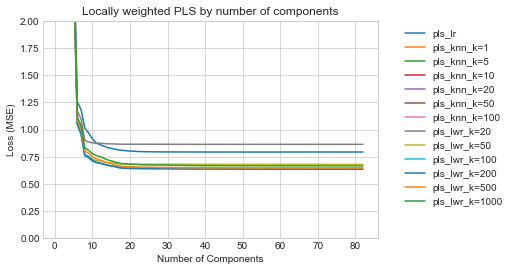

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PLS by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_pls.png",bbox_inches='tight')

ax.set_ylim(0,2)
plt.savefig(log_dir / f"mse_plot_pls_compressed.png",bbox_inches='tight')


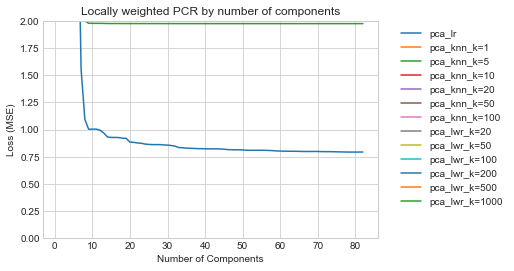

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PCR by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_pca.png",bbox_inches='tight')

ax.set_ylim(0,2)
plt.savefig(log_dir / f"mse_plot_pca_compressed.png",bbox_inches='tight')


In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PLS by number of components")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pls_v2.png",bbox_inches='tight')


SyntaxError: EOL while scanning string literal (<ipython-input-15-5714fcec3fe0>, line 3)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PCR by number of components")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pcr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pcr_v2.png",bbox_inches='tight')
